In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('anomalies/anomalies_train.csv');

In [3]:
# Add 'is_internal' flag for logs with no client_ip
df['is_internal'] = df['internal_ip'].isnull()

# Refined anomaly logic: exclude internal logs
error_status_codes = [500, 503, 404]  # Include 404 for monitoring
response_time_threshold = df['response_time'].quantile(0.99)  # Adjust threshold if needed

df['is_anomalous'] = (
    (~df['is_internal']) &  # Only include external logs
    ((df['status_code'].isin(error_status_codes)) | 
     (df['response_time'] > response_time_threshold))
)

# Save internal and external logs separately for further analysis
internal_logs = df[df['is_internal']]
external_logs = df[~df['is_internal']]

internal_logs.to_csv("anomalies/train_internal_logs.csv", index=False)
external_logs.to_csv("anomalies/train_external_logs.csv", index=False)

print("Refined anomaly detection complete. Internal and external logs separated.")


Refined anomaly detection complete. Internal and external logs separated.


Top 5 sources generating 404 errors:
 source
nova.osapi_compute.wsgi.server    1312
nova.metadata.wsgi.server         1216
Name: count, dtype: int64


/var/folders/wk/l8__rsrn5v73832q54dxsh480000gn/T/ipykernel_13824/2077364153.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors_404['timestamp'] = pd.to_datetime(errors_404['timestamp'], errors='coerce')


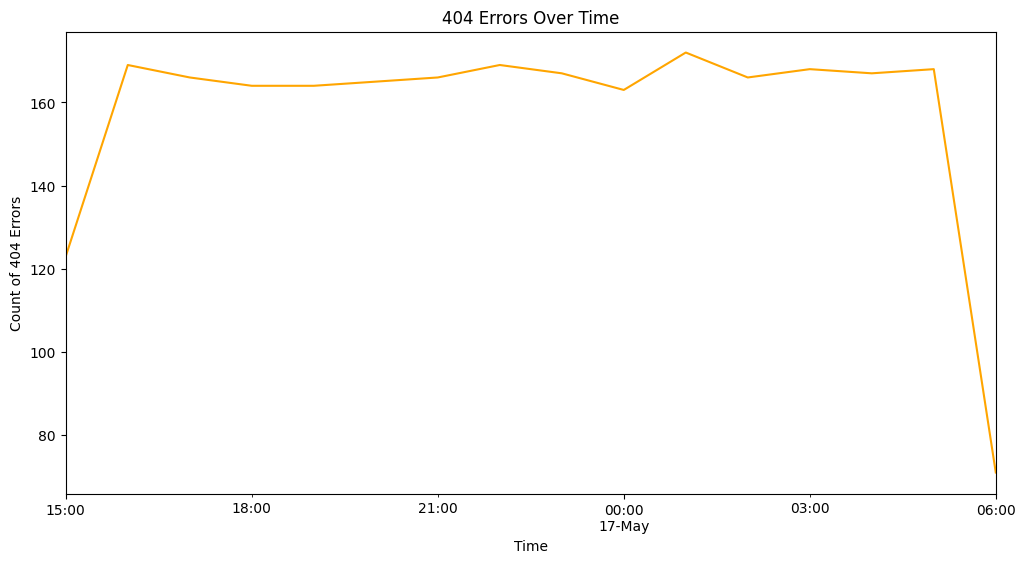

In [4]:
# Analyze 404 errors
errors_404 = external_logs[external_logs['status_code'] == 404]

# Group by source and timestamp
top_404_sources = errors_404['source'].value_counts().head(5)
print("Top 5 sources generating 404 errors:\n", top_404_sources)

# Visualize 404 errors over time
if 'timestamp' in errors_404.columns:
    errors_404['timestamp'] = pd.to_datetime(errors_404['timestamp'], errors='coerce')
    errors_404_time = errors_404.resample('H', on='timestamp').size()

    plt.figure(figsize=(12, 6))
    errors_404_time.plot(kind='line', color='orange', title="404 Errors Over Time")
    plt.xlabel('Time')
    plt.ylabel('Count of 404 Errors')
    plt.show()
